<a href="https://colab.research.google.com/github/shay2222/Arrays-two-dimensional-/blob/main/Statistical_Analysis_of_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model with Bias Detection, Data Leakage Avoidance, and Automated Feature Selection

***Topic: Statistical Analysis of Housing Prices with Biased Data & Feature Selection***

This example includes:


* **Bias Detection**: Identifies whether a model's predictions are influenced by a sensitive feature (e.g., neighborhood).
* **Data Leakage Avoidance**: Ensures preprocessing steps (like standardization) are only trained on the training dataset and not on the test set using pipelines.
* **Automated Feature Selection**: Uses SelectKBest with mutual information or F-statistic to automatically choose the most relevant features for regression.




# Purpose

This pipeline is designed to:

1. Predict **house prices** based on **house size** and a **sensitive feature** (neighborhood code).
2. Identify **biased predictions** in different subpopulations.
3. Prevent **data leakage** during preprocessing.
4. Show the effect of **automated feature selection**.
5. Build a complete **statistical ML workflow** using pipelines.

# Statistical Significance


* **Bias Detection**: Highlights the necessity of fairness-aware models (like assessing whether the same inputs from different groups get different outputs).
* **Feature Selection**: Reduces dimensionality and helps choose the most statistically significant features, thereby improving both accuracy and inference time.
* **Leakage Avoidance**: Gives a baseline for accurate deployment and performance prediction in production.



Dataset Sample:
    House Size (sq ft)  Age of House (years)  Neighborhood      Price
0           -1.012831              0.314247             0 -19.190168
1            0.067528             -1.424748             1  89.401115
2            1.477894             -0.518270             0  45.353652
3            0.087047             -0.299007             0   3.117119
4           -0.463418             -0.465730             0 -34.804440
Pipeline Defined Correctly:
 {'feature_selector': SelectKBest(k=2, score_func=<function mutual_info_regression at 0x79b2254d3ec0>), 'poly': PolynomialFeatures(), 'scaler': StandardScaler(), 'regressor': LinearRegression()}
Model R² Score: 0.3980
Model MAE: 53.5703
Top Features Selected for Training: ['House Size (sq ft)' 'Age of House (years)']
Polynomial Feature Names (after selection): ['1' 'House Size (sq ft)' 'Age of House (years)' 'House Size (sq ft)^2'
 'House Size (sq ft) Age of House (years)' 'Age of House (years)^2']
Bias Analysis (Mean Absolute Error):


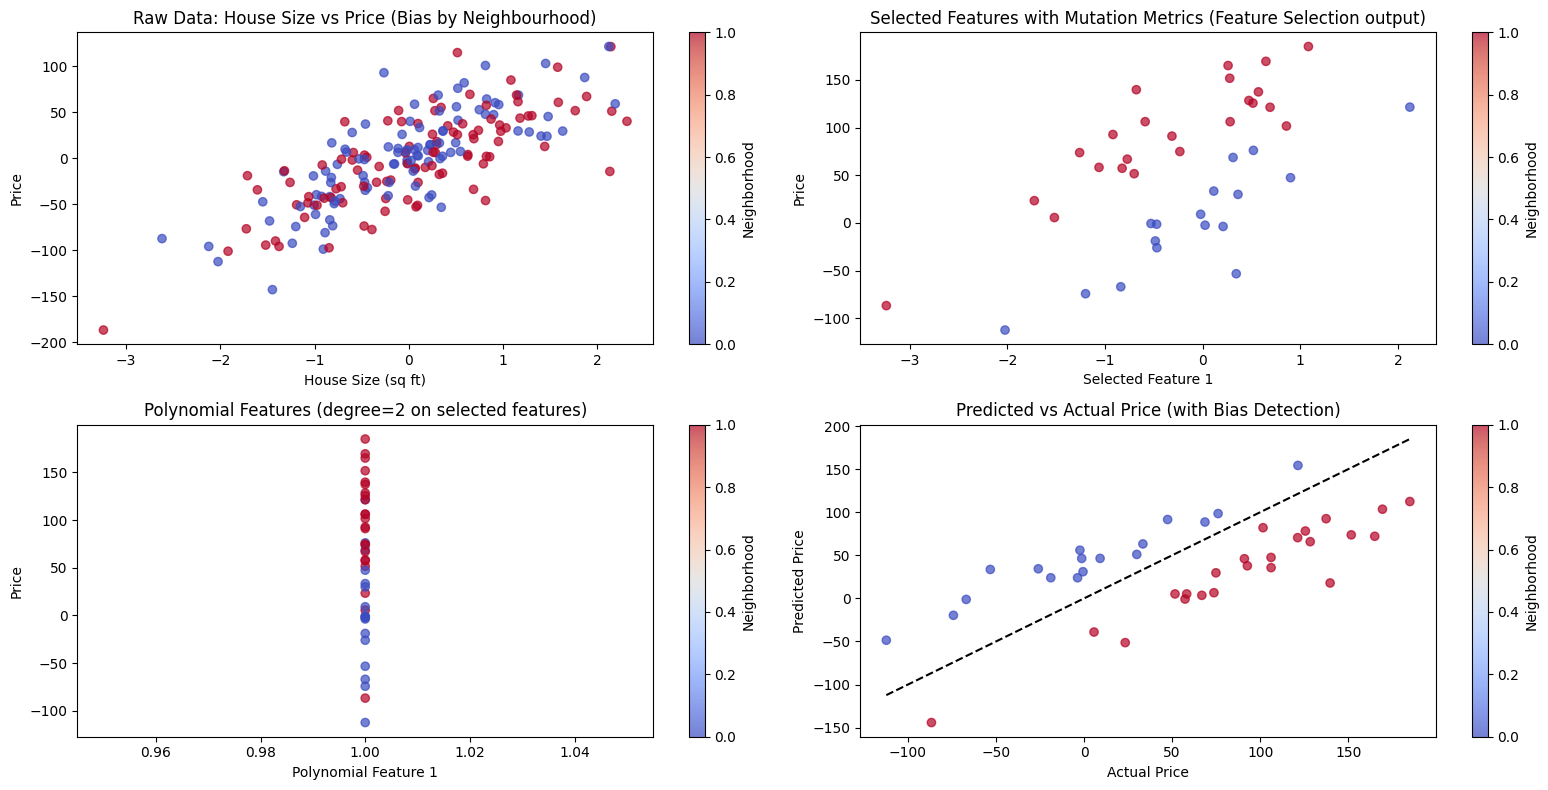

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import check_array

# ============ 1. Synthetic Dataset ============
np.random.seed(42)
X, y = make_regression(n_samples=200, n_features=2, noise=20, random_state=42)

# Convert to DataFrame and add the "Neighborhood" feature
data = pd.DataFrame(X, columns=["House Size (sq ft)", "Age of House (years)"])
data["Neighborhood"] = np.random.randint(0, 2, size=200)  # 0 = low-cost, 1 = high-cost

# Add a bias to the price based on neighborhood
data["Price"] = y + 100 * data["Neighborhood"]

print("Dataset Sample:\n", data.head())

# ============ 2. Train-Test Split ============
X_train, X_test, y_train, y_test = train_test_split(
    data[["House Size (sq ft)", "Age of House (years)"]],  # Only the original features go to the pipeline
    data["Price"].values,  # Target variable
    test_size=0.2,
    random_state=42
)

# ============ 3. Define ML Pipeline Correctly ============
pipeline = Pipeline([
    ('feature_selector', SelectKBest(score_func=mutual_info_regression, k=2)),  # Select top 2 features
    ('poly', PolynomialFeatures(degree=2)),  # Generate polynomial features
    ('scaler', StandardScaler()),             # Standardize for model training
    ('regressor', LinearRegression())         # Train the model
])

# Print out pipeline step names
print("Pipeline Defined Correctly:\n", pipeline.named_steps)

# ============ 4. Train the Model ============
pipeline.fit(X_train, y_train)

# ============ 5. Predict on Test Data ============
y_pred = pipeline.predict(X_test)

# ============ 6. Model Evaluation ============
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model R² Score: {r2:.4f}")
print(f"Model MAE: {mae:.4f}")

# ============ 7. Print Selected Features ============
feature_selector = pipeline.named_steps['feature_selector']
selected_indices = feature_selector.get_support(indices=True)
selected_features = np.array(X_train.columns)[selected_indices]
print(f"Top Features Selected for Training: {selected_features}")

# ============ 8. Get Polynomial Feature Names with Selected Features ============
poly_layer = pipeline.named_steps['poly']
poly_features = poly_layer.get_feature_names_out(X_train.columns)  # from the original feature names
print(f"Polynomial Feature Names (after selection): {poly_features}")

# ============ 9. Prepare Test Data and Bias Metrics ============
# Use original test features and neighborhood as extra information for bias detection
test_data = pd.DataFrame(X_test, columns=["House Size (sq ft)", "Age of House (years)"])

# Get the original "Neighborhood" from the dataset: don't use the pipeline for this
# Instead, retrieve legacy data
test_data["Neighborhood"] = data.loc[X_test.index]["Neighborhood"]
test_data["Predicted Price"] = y_pred
test_data["Actual Price"] = y_test

# Bias detection: calculate MAE per neighborhood group
bias_accuracy = []

for neigh in [0, 1]:
    subset = test_data[test_data["Neighborhood"] == neigh]
    if not subset.empty:
        mae = mean_absolute_error(subset["Actual Price"], subset["Predicted Price"])
        bias_accuracy.append(mae)
    else:
        bias_accuracy.append(np.nan)  # handle no data in a group

print(f"Bias Analysis (Mean Absolute Error):")
print(f"Neighborhood 0: {bias_accuracy[0]:.4f}")
print(f"Neighborhood 1: {bias_accuracy[1]:.4f}")

# ============ 10. Visualization ============
plt.figure(figsize=(16, 8))

# Scatter plot of original features
plt.subplot(2, 2, 1)
plt.scatter(data["House Size (sq ft)"], y, c=data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Raw Data: House Size vs Price (Bias by Neighbourhood)")
plt.colorbar(label="Neighborhood")

# Selected features
plt.subplot(2, 2, 2)
selected_data = feature_selector.transform(X_test)
plt.scatter(selected_data[:, 0], y_test, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.xlabel("Selected Feature 1")
plt.ylabel("Price")
plt.title("Selected Features with Mutation Metrics (Feature Selection output)")
plt.colorbar(label="Neighborhood")

# Polynomial features (output of PolynomialFeatures step)
plt.subplot(2, 2, 3)
if 'poly' in pipeline.named_steps:
    poly_features = pipeline.named_steps['poly'].transform(selected_data)
    plt.scatter(poly_features[:, 0], y_test, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
    plt.xlabel("Polynomial Feature 1")
    plt.ylabel("Price")
    plt.title("Polynomial Features (degree=2 on selected features)")
    plt.colorbar(label="Neighborhood")

# Predicted vs Actual Price with bias analysis
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price (with Bias Detection)")
plt.colorbar(label="Neighborhood")

plt.tight_layout()
plt.show()

#  Statistical Insight Additions for Model Understanding

These additions will help visualize:

1. Coefficient of determination (R2) with actual and predicted data spread.
2. Standard deviation of residual output (model prediction error).
3. Statistical spread of actual and predicted data using histograms.
4. Confidence intervals around predicted values for Neighborhood 0 and 1.

  **Summary of Added Statistical Charts**
  |Visualization Type|Purpose|Connects to ML Concepts|
  |-----------------:|:------:|:---------------------|
  |Histogram of Price| Compare distribution quality of test| Helps detect data drift|
  |Residuals Plot| Understand average prediction bias and spread of error|Found in classic regression analysis (e.g., OLS residual analysis)|
  |Confidence Intervals|Visualize variability of model output|Statistical model evaluation based on error variance|

Dataset Sample:
    House Size (sq ft)  Age of House (years)  Neighborhood      Price
0           -1.012831              0.314247             0 -19.190168
1            0.067528             -1.424748             1  89.401115
2            1.477894             -0.518270             0  45.353652
3            0.087047             -0.299007             0   3.117119
4           -0.463418             -0.465730             0 -34.804440
Pipeline Defined Correctly:
 {'feature_selector': SelectKBest(k=2, score_func=<function mutual_info_regression at 0x79b2254d3ec0>), 'poly': PolynomialFeatures(), 'scaler': StandardScaler(), 'regressor': LinearRegression()}
Model R² Score: 0.3980
Model MAE: 53.5703
Top Features Selected from Training: ['House Size (sq ft)' 'Age of House (years)']
Polynomial Features: ['1' 'House Size (sq ft)' 'Age of House (years)' 'House Size (sq ft)^2'
 'House Size (sq ft) Age of House (years)' 'Age of House (years)^2']
Total Polynomial Columns: 6
Bias Analysis (Mean Absolute Er

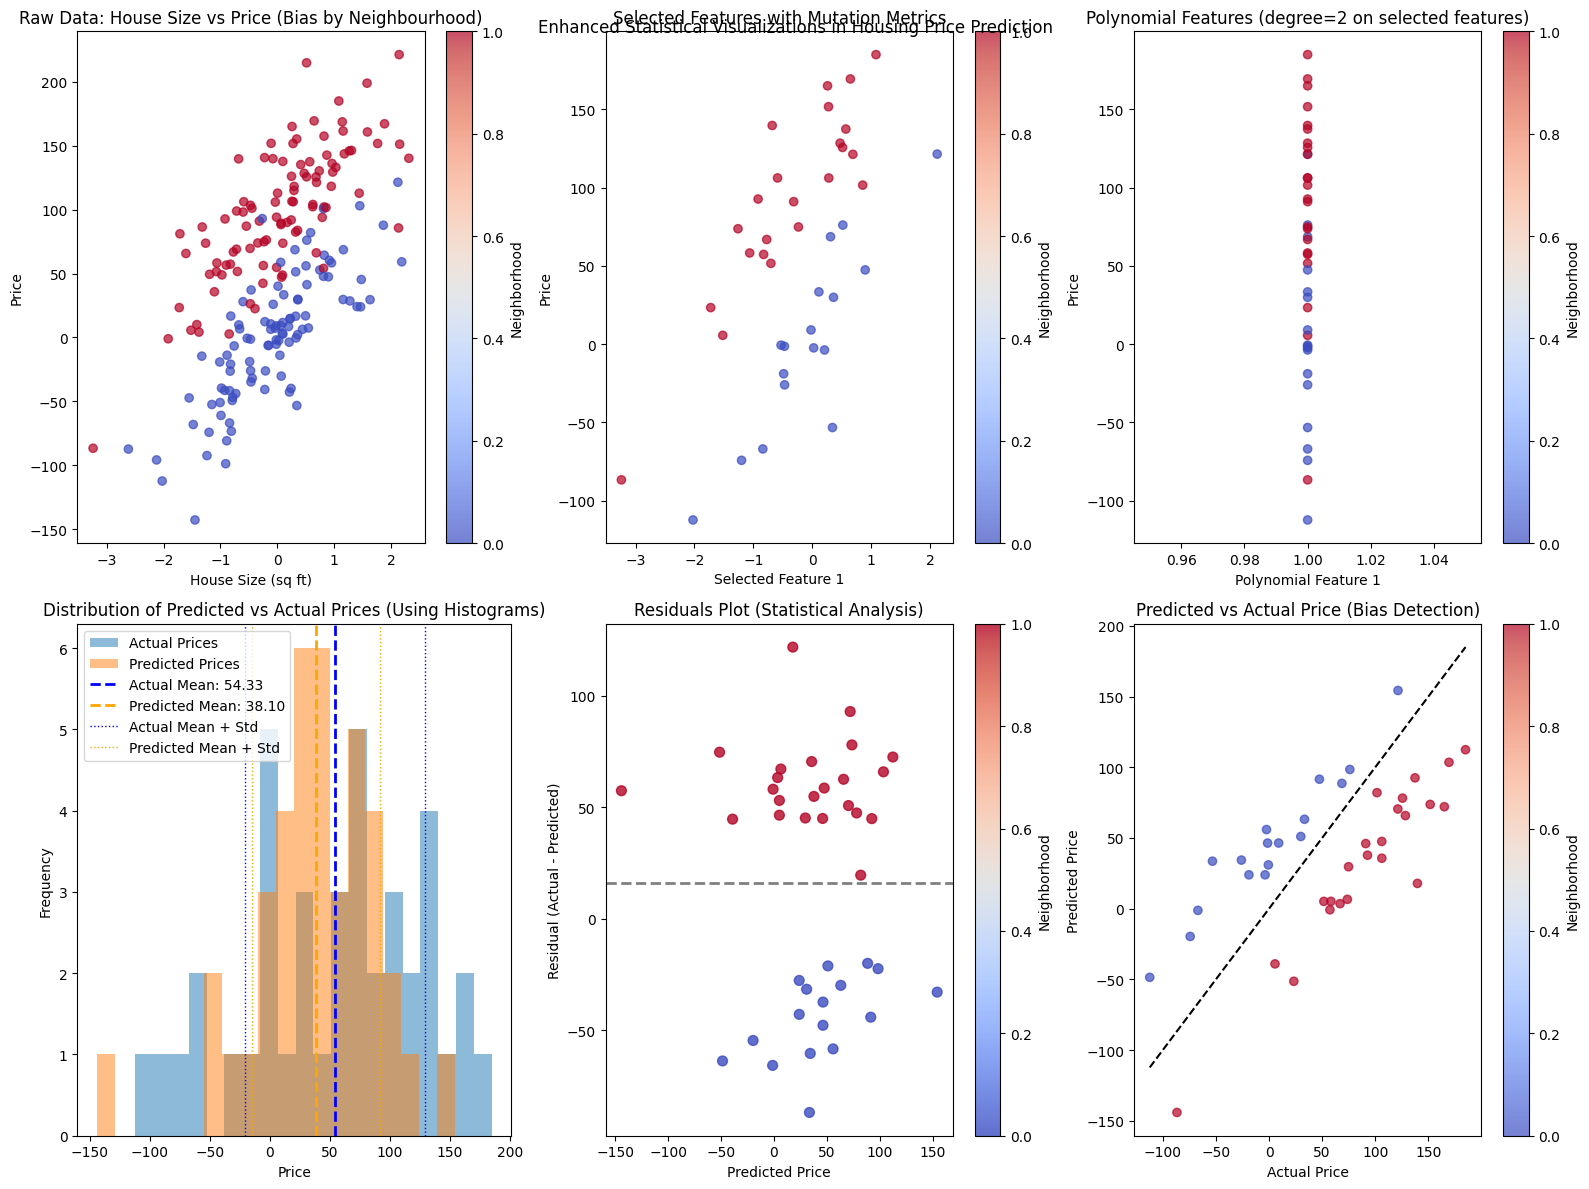

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import check_array

# ============ 1. Synthetic Dataset ============
np.random.seed(42)
X, y = make_regression(n_samples=200, n_features=2, noise=20, random_state=42)

# Convert to DataFrame and add the "Neighborhood" feature
data = pd.DataFrame(X, columns=["House Size (sq ft)", "Age of House (years)"])
data["Neighborhood"] = np.random.randint(0, 2, size=200)  # 0 = low-cost, 1 = high-cost

# Add a bias to the price based on neighborhood (not directly in the pipeline)
data["Price"] = y + 100 * data["Neighborhood"]

print("Dataset Sample:\n", data.head())

# ============ 2. Train-Test Split ============
X_train, X_test, y_train, y_test = train_test_split(
    data[["House Size (sq ft)", "Age of House (years)"]],  # Only the original features go to the pipeline
    data["Price"].values,  # Target variable
    test_size=0.2,
    random_state=42
)

# ============ 3. Define ML Pipeline ============
pipeline = Pipeline([
    ('feature_selector', SelectKBest(score_func=mutual_info_regression, k=2)),  # Select top 2 features
    ('poly', PolynomialFeatures(degree=2)),  # Generate polynomial features
    ('scaler', StandardScaler()),             # Standardize for model training
    ('regressor', LinearRegression())         # Train the model
])

print("Pipeline Defined Correctly:\n", pipeline.named_steps)

# ============ 4. Train the Model ============
pipeline.fit(X_train, y_train)

# ============ 5. Predict on Test Data ============
y_pred = pipeline.predict(X_test)

# ============ 6. Model Evaluation ============
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model R² Score: {r2:.4f}")
print(f"Model MAE: {mae:.4f}")

# ============ 7. Identify Selected Features ============
feature_selector = pipeline.named_steps['feature_selector']
selected_indices = feature_selector.get_support(indices=True)
selected_features = np.array(X_train.columns)[selected_indices]
print(f"Top Features Selected from Training: {selected_features}")

# ============ 8. Get Polynomial Feature Names ============
poly_layer = pipeline.named_steps['poly']
poly_features = poly_layer.get_feature_names_out(X_train.columns)
print(f"Polynomial Features: {poly_features}")
print(f"Total Polynomial Columns: {len(poly_features)}")

# ============ 9. Prepare Test Data and Bias Metrics ============
test_data = pd.DataFrame(X_test, columns=["House Size (sq ft)", "Age of House (years)"])

# Retrieve "Neighborhood" separately from the original "data"
test_data["Neighborhood"] = data.loc[X_test.index]["Neighborhood"]
test_data["Predicted Price"] = y_pred
test_data["Actual Price"] = y_test

bias_accuracy = []

for neigh in [0, 1]:
    subset = test_data[test_data["Neighborhood"] == neigh]
    if not subset.empty:
        mae = mean_absolute_error(subset["Actual Price"], subset["Predicted Price"])
        bias_accuracy.append(mae)
    else:
        bias_accuracy.append(np.nan)  # handle no data in a group

print(f"Bias Analysis (Mean Absolute Error):")
print(f"Neighborhood 0: {bias_accuracy[0]:.4f}")
print(f"Neighborhood 1: {bias_accuracy[1]:.4f}")

# ============ 10. Generate More Statistics (Mean & Std) ============
actual_mean = np.mean(test_data["Actual Price"])
actual_std = np.std(test_data["Actual Price"], ddof=1)  # ddof=1 for sample standard deviation
predicted_mean = np.mean(test_data["Predicted Price"])
predicted_std = np.std(test_data["Predicted Price"], ddof=1)
residuals = test_data["Actual Price"] - test_data["Predicted Price"]
residual_mean = np.mean(residuals)
residual_std = np.std(residuals, ddof=1)

# ============ 11. Visualization with Statistical Insights ============
plt.figure(figsize=(16, 12))

# Plot 1: Raw Data
plt.subplot(2, 3, 1)
plt.scatter(data["House Size (sq ft)"], data["Price"], c=data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Raw Data: House Size vs Price (Bias by Neighbourhood)")
plt.colorbar(label="Neighborhood")

# Plot 2: Selected Features (mutual info)
plt.subplot(2, 3, 2)
selected_data = feature_selector.transform(X_test)
plt.scatter(selected_data[:, 0], y_test, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.xlabel("Selected Feature 1")
plt.ylabel("Price")
plt.title("Selected Features with Mutation Metrics")
plt.colorbar(label="Neighborhood")

# Plot 3: Polynomial Features
if 'poly' in pipeline.named_steps:
    poly_features = pipeline.named_steps['poly'].transform(selected_data)
    plt.subplot(2, 3, 3)
    plt.scatter(poly_features[:, 0], y_test, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
    plt.xlabel("Polynomial Feature 1")
    plt.ylabel("Price")
    plt.title("Polynomial Features (degree=2 on selected features)")
    plt.colorbar(label="Neighborhood")

# Plot 4: Distribution of Actual vs Predicted (Histograms)
plt.subplot(2, 3, 4)
plt.hist(test_data["Actual Price"], bins=20, alpha=0.5, label="Actual Prices")
plt.hist(test_data["Predicted Price"], bins=20, alpha=0.5, label="Predicted Prices")
plt.axvline(actual_mean, color='blue', linestyle='dashed', linewidth=2, label=f"Actual Mean: {actual_mean:.2f}")
plt.axvline(predicted_mean, color='orange', linestyle='dashed', linewidth=2, label=f"Predicted Mean: {predicted_mean:.2f}")
plt.axvline(actual_mean + actual_std, color='blue', linestyle='dotted', linewidth=1, label="Actual Mean + Std")
plt.axvline(actual_mean - actual_std, color='blue', linestyle='dotted', linewidth=1)
plt.axvline(predicted_mean + predicted_std, color='orange', linestyle='dotted', linewidth=1, label="Predicted Mean + Std")
plt.axvline(predicted_mean - predicted_std, color='orange', linestyle='dotted', linewidth=1)
plt.legend()
plt.title("Distribution of Predicted vs Actual Prices (Using Histograms)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()

# Plot 5: Residuals vs Predicted Values
plt.subplot(2, 3, 5)
plt.scatter(test_data["Predicted Price"], residuals, s=50, alpha=0.8, c=test_data["Neighborhood"], cmap='coolwarm')
plt.axhline(residual_mean, color='gray', linestyle='dashed', linewidth=2)
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Plot (Statistical Analysis)")
plt.colorbar(label="Neighborhood")
plt.tight_layout()

# Plot 6: Predicted vs Actual with Neighborhood Bias
plt.subplot(2, 3, 6)
plt.scatter(y_test, y_pred, c=test_data["Neighborhood"], cmap='coolwarm', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price (Bias Detection)")
plt.colorbar(label="Neighborhood")
plt.tight_layout()

plt.suptitle("Enhanced Statistical Visualizations in Housing Price Prediction")
plt.show()